# 탐색적 데이터 분석 (자전거 수요 맞추기)

## 탐색적으로 데이터를 사전에 여러 가지 방법을 통해 살펴보다가 풍속(windspped)이 다 0에 몰려있는것을 확인하고
## 이를 랜덤포레스트를 통해 처리 하여서 다시 데이터를 재조합하였고 
## train 데이터와 test 데이터들의 categorical 변수들을 지정해주고 모델(RF)에 돌렸다

In [6]:
#window 기본 세팅
import os
from os import chdir
print(os.getcwd())
chdir('C:\\Users\\User\\Desktop')

C:\Users\User\Desktop


In [7]:
# 필요한 라이브러리 세팅
import pandas as pd
import numpy as np
import matplotlib as mpl 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


%matplotlib inline

# 그래프에서 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일을 사용
plt.style.use('ggplot')

#그래프에서 마이너스 폰트 꺠지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus']=False

## 지난번 그레디언드 부스팅 떄는 train 데이터로 7:3 비율로 모델을 학습시키고 test데이터는 제출할떄만 사용했지만
## 요번엔 train데이터와 test 데이터를 불러와 사전에 split 하지 않고 바로 사용

In [8]:
train=pd.read_csv("train_1.csv",parse_dates=["datetime"])
train.shape

(10886, 12)

In [9]:
test=pd.read_csv("test_1.csv",parse_dates=["datetime"])
test.shape

(6493, 9)

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null datetime64[ns]
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.6 KB


In [11]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [12]:
train.temp.describe()

count    10886.00000
mean        20.23086
std          7.79159
min          0.82000
25%         13.94000
50%         20.50000
75%         26.24000
max         41.00000
Name: temp, dtype: float64

In [13]:
#null 인 데이터는 없당
train.isnull().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

## Feature Engineering

In [14]:
train["year"]=train["datetime"].dt.year
train["month"]=train["datetime"].dt.month
train["day"]=train["datetime"].dt.day
train["hour"]=train["datetime"].dt.hour
train["minute"]=train["datetime"].dt.minute
train["second"]=train["datetime"].dt.second
train.shape

(10886, 18)

In [15]:
test["year"]  =  test["datetime"].dt.year
test["month"] = test["datetime"].dt.month
test["day"] = test["datetime"].dt.day
test["hour"] = test["datetime"].dt.hour
test["minute"] = test["datetime"].dt.minute
test["second"] = test["datetime"].dt.second
test["dayofweek"] = test["datetime"].dt.dayofweek
test.shape

(6493, 16)

In [16]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,0,0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,0,0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,0,0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,0,0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,0,0


C:\Users\User\Anaconda3\anaconda\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


[Text(0,0.5,'hour'), Text(0.5,1,'Rental amount per hour')]

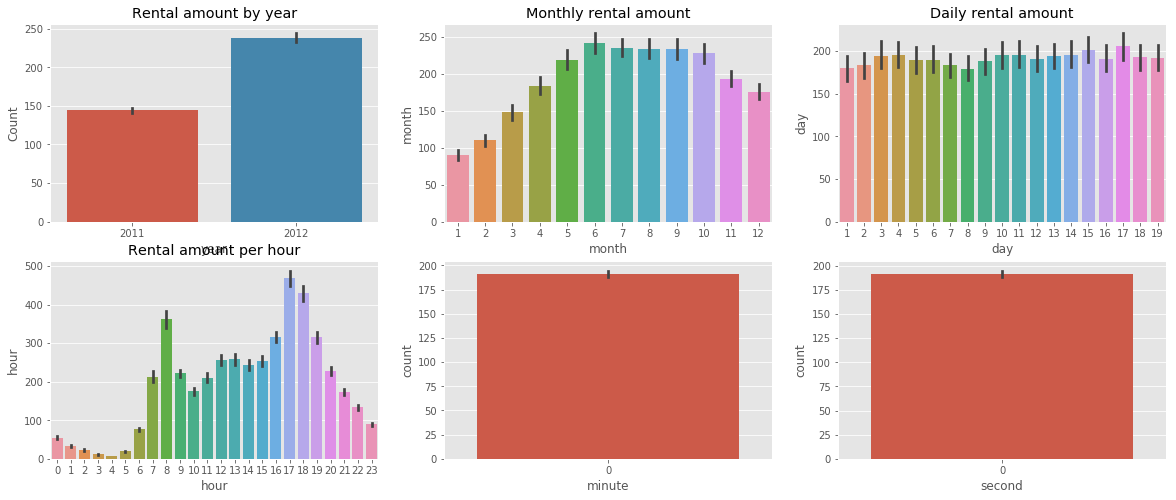

In [17]:
figure,((ax1,ax2,ax3),(ax4,ax5,ax6))=plt.subplots(nrows=2,ncols=3)
figure.set_size_inches(20,8)

sns.barplot(data=train,x="year",y="count",ax=ax1)
sns.barplot(data=train,x="month",y="count",ax=ax2)
sns.barplot(data=train,x="day",y="count",ax=ax3)
sns.barplot(data=train,x="hour",y="count",ax=ax4)
sns.barplot(data=train,x="minute",y="count",ax=ax5)
sns.barplot(data=train,x="second",y="count",ax=ax6)

ax1.set(ylabel='Count',title="Rental amount by year")
ax2.set(ylabel='month',title="Monthly rental amount")
ax3.set(ylabel='day',title="Daily rental amount")
ax4.set(ylabel='hour',title="Rental amount per hour")

* 연도별 대여량은 2012년이 2011년보다 많음..
* 월별 대여량은 6월이 가장 많으며 200이상으로 5~9월이 있겠다
* 일별 사용량은 1일부터 19일까지 있는데 나머지는 test.csv에 있기에 이 변수는 피처로 사용불가
* minute,second변수 0이므로 의미없음 -->삭제
* 시간대를 보면 ... 출퇴근 시간대에 가장 사용량(count)가 많은 것을 볼 수 있다.

C:\Users\User\Anaconda3\anaconda\lib\site-packages\seaborn\categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


[Text(0,0.5,'Count'),
 Text(0.5,0,'Working Day'),
 Text(0.5,1,'Rental amount according to working days')]

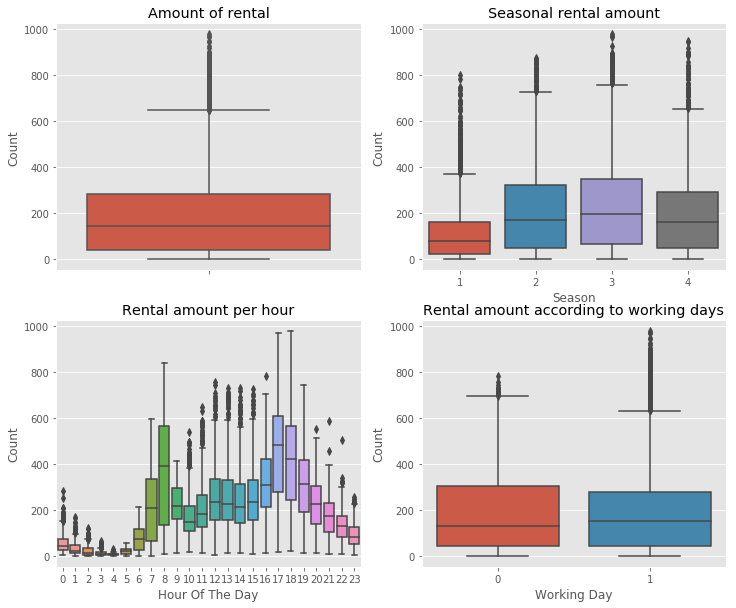

In [18]:
fig, axes= plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12,10)
sns.boxplot(data=train,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=train,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=train,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=train,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Amount of rental")
axes[0][1].set(xlabel='Season',ylabel='Count',title="Seasonal rental amount")
axes[1][0].set(xlabel='Hour Of The Day',ylabel='Count',title="Rental amount per hour")
axes[1][1].set(xlabel='Working Day',ylabel='Count',title="Rental amount according to working days")


* 일을 쉬는날이 count가 더 많은 것을 볼 수 있다..!

In [19]:
train["dayofweek"]=train["datetime"].dt.dayofweek
train.shape

(10886, 19)

In [20]:
#월화수목금 but 별차이가 없다
train["dayofweek"].value_counts()

5    1584
6    1579
3    1553
2    1551
0    1551
1    1539
4    1529
Name: dayofweek, dtype: int64

C:\Users\User\Anaconda3\anaconda\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)
C:\Users\User\Anaconda3\anaconda\lib\site-packages\seaborn\categorical.py:1508: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data[hue_mask])


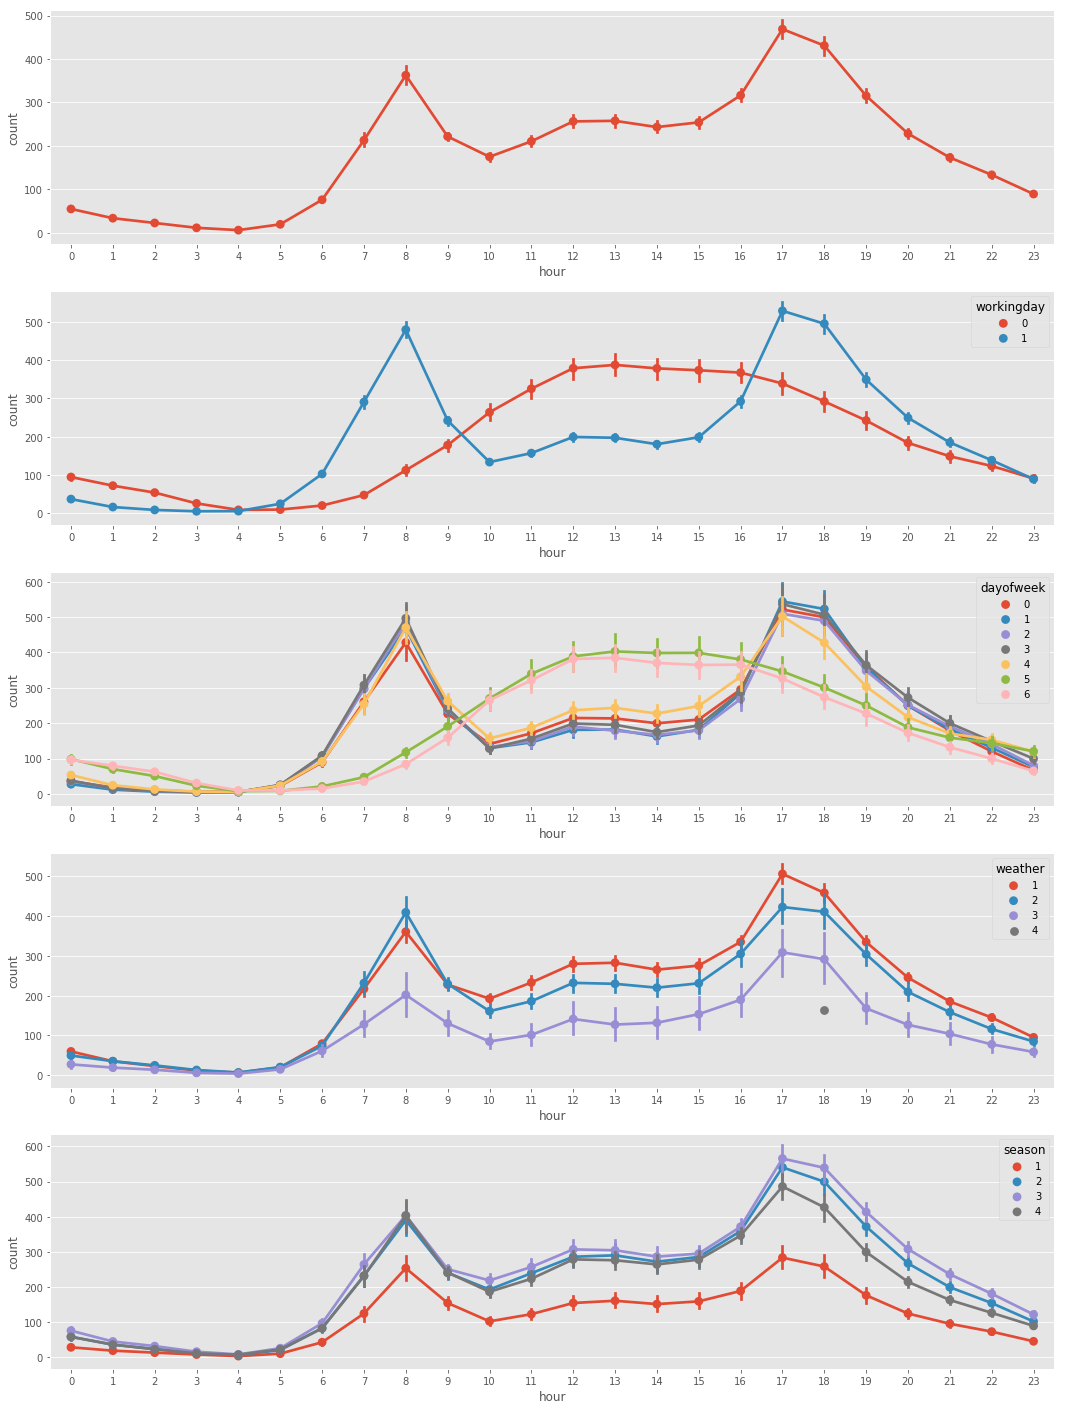

In [21]:
fig,(ax1,ax2,ax3,ax4,ax5)=plt.subplots(nrows=5)
fig.set_size_inches(18,25)

sns.pointplot(data=train,x="hour",y="count",ax=ax1)
sns.pointplot(data=train,x="hour",y="count",hue="workingday",ax=ax2)
sns.pointplot(data=train,x="hour",y="count",hue="dayofweek",ax=ax3)
sns.pointplot(data=train,x="hour",y="count",hue="weather",ax=ax4)
sns.pointplot(data=train,x="hour",y="count",hue="season",ax=ax5)

* ax2를 보면 쉬는날엔 오전10시부터 오후17시까지 사용량이 높고 워킹데이는 역시 출퇴근시간이 가장 높은 것을 알 수 있음

In [22]:
#히트맵으로 보자
corrMatt= train[["temp","atemp","casual","registered","humidity","windspeed","count","season","weather"]]
corrMatt=corrMatt.corr()
print(corrMatt)

mask=np.array(corrMatt)
mask[np.tril_indices_from(mask)]= False

                temp     atemp    casual  registered  humidity  windspeed  \
temp        1.000000  0.984948  0.467097    0.318571 -0.064949  -0.017852   
atemp       0.984948  1.000000  0.462067    0.314635 -0.043536  -0.057473   
casual      0.467097  0.462067  1.000000    0.497250 -0.348187   0.092276   
registered  0.318571  0.314635  0.497250    1.000000 -0.265458   0.091052   
humidity   -0.064949 -0.043536 -0.348187   -0.265458  1.000000  -0.318607   
windspeed  -0.017852 -0.057473  0.092276    0.091052 -0.318607   1.000000   
count       0.394454  0.389784  0.690414    0.970948 -0.317371   0.101369   
season      0.258689  0.264744  0.096758    0.164011  0.190610  -0.147121   
weather    -0.055035 -0.055376 -0.135918   -0.109340  0.406244   0.007261   

               count    season   weather  
temp        0.394454  0.258689 -0.055035  
atemp       0.389784  0.264744 -0.055376  
casual      0.690414  0.096758 -0.135918  
registered  0.970948  0.164011 -0.109340  
humidity   -0.

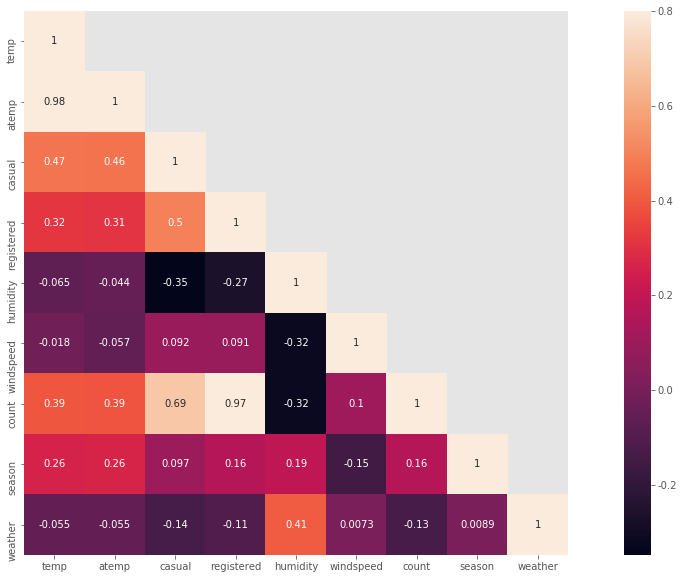

In [23]:
fig, ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt,mask=mask,vmax=.8,square=True,annot=True)

* 대여량(count)와 가장 관련이 높은건 registered이지만 test데이터에 이 값이 없음
* atemp와 temp의 상관관계는 0.98로 높지만 온도 및 체감온도를 피처로 사용하기엔..음.... 글쎄.... 연관성이 있을까 ㅋㅋ

In [24]:
# 년도와 월을 합치는 함수
def concat_year_month(datetime):
    return "{0}-{1}" .format(datetime.year,datetime.month)

train["year_month"]=train["datetime"].apply(concat_year_month)

print(train.shape)
train[["datetime","year_month"]].head()

(10886, 20)


,datetime,year_month
0,2011-01-01 00:00:00,2011-1
1,2011-01-01 01:00:00,2011-1
2,2011-01-01 02:00:00,2011-1
3,2011-01-01 03:00:00,2011-1
4,2011-01-01 04:00:00,2011-1


C:\Users\User\Anaconda3\anaconda\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


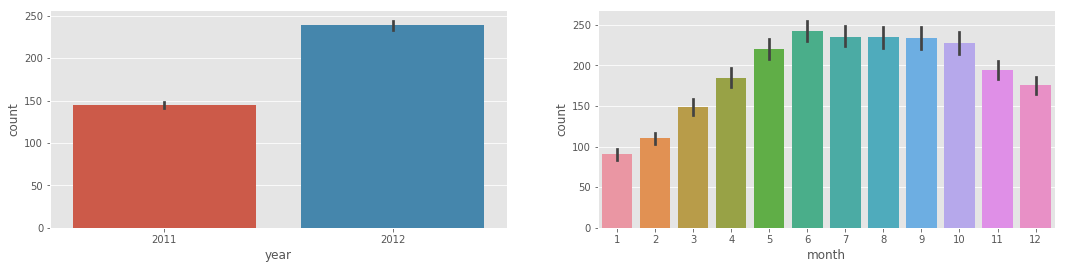

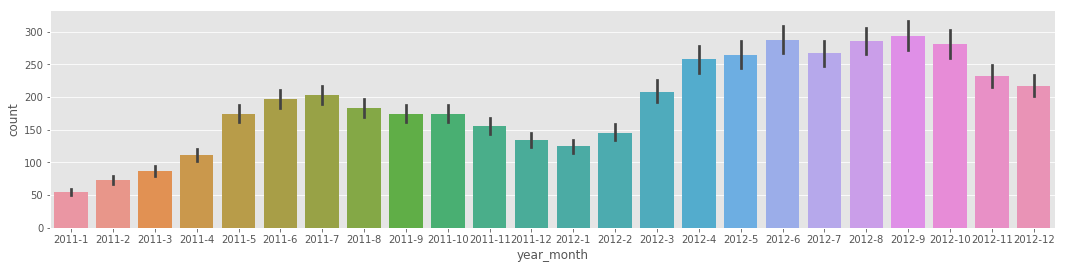

In [25]:
fig,(ax1,ax2)=plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(18,4)

sns.barplot(data=train,x="year",y="count",ax=ax1)
sns.barplot(data=train,x="month",y="count",ax=ax2)

fig,ax3=plt.subplots(nrows=1,ncols=1)
fig.set_size_inches(18,4)

sns.barplot(data=train,x="year_month",y="count",ax=ax3)

* ax3을 보면 시간이 흐르면서 계속해서 대여량은 증가함을 볼 수 있다
* 그리고 여름에서 가을(6~10)에 11,12년도 대여량이 높은 것을 볼 수 있다.

In [26]:
#outlier제거
trainWithoutOutliers=train[np.abs(train["count"]-train["count"].mean())<=(3*train["count"].std())]
# 이건 어떤 방식으로 outlier를 처리한걸까

print(train.shape)
print(trainWithoutOutliers.shape)

(10886, 20)
(10739, 20)


* 아웃라이어의 정의:데이터의 분포를 정규분포로 가정하고(또는 우기고) 평균으로 부터 ±표준편차 * 시그마계수를 벗어나면 아웃라이어(outlier, 이상치)라고 판단하는 것을 말한다. 
* 위에 식은 3시그마를 벗어난 값들을 이상치로 보고 있다.
* 참고로 np.abs()는 절대값 리턴

((array([-3.82819677, -3.60401975, -3.48099008, ...,  3.48099008,
          3.60401975,  3.82819677]),
  array([ 0.69314718,  0.69314718,  0.69314718, ...,  6.5971457 ,
          6.59850903,  6.5998705 ])),
 (1.3486990121229776, 4.5624238680878078, 0.95811767809096116))

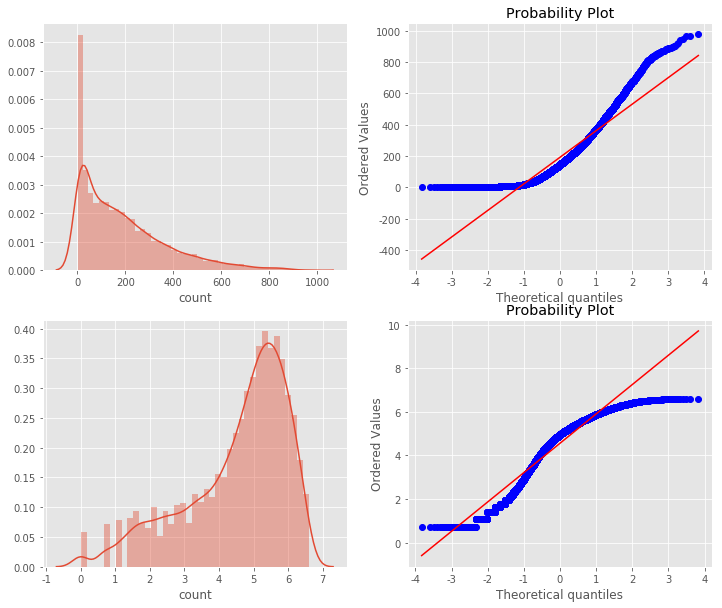

In [115]:
# count값의 데이터 분포도를 파악

figure, axes = plt.subplots(ncols=2, nrows=2)
figure.set_size_inches(12, 10)

sns.distplot(train["count"], ax=axes[0][0])
stats.probplot(train["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(trainWithoutOutliers["count"]), ax=axes[1][0])
stats.probplot(np.log1p(trainWithoutOutliers["count"]), dist='norm', fit=True, plot=axes[1][1])

* 
count변수가 오른쪽에 치우쳐져 있다. 대부분의 기계학습은 종속변수가 normal 이어야 하기에 정규분포를 갖는 것이 바람직하다. 대안으로 outlier data를 제거하고 "count"변수에 로그를 씌워 변경해 봐도 정규분포를 따르지는 않지만 이전 그래프보다는 좀 더 자세히 표현하고 있다.

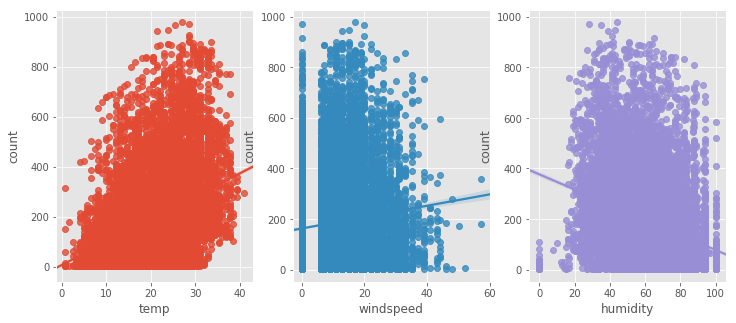

In [28]:
fig,(ax1,ax2,ax3)=plt.subplots(ncols=3)
fig.set_size_inches(12,5)
sns.regplot(x="temp",y="count",data=train,ax=ax1)
sns.regplot(x="windspeed",y="count",data=train,ax=ax2)
sns.regplot(x="humidity",y="count",data=train,ax=ax3)

* 풍속의 경우 0에 숫자가 몰려 있는 것으로 보인다. 아마도 관측되지 않은 수치에 대해 0으로 기록된 것이 아닐까 추측해본당

* If either predicted or the actual value is big: RMSE > RMSLE
* RMSLE is usually used when you don't want to penalize huge differences in the predicted and the actual values when both predicted and true values are huge numbers.
* RMSE treated them equally however RMSLE penalized the under estimate more than over estimate.

In [29]:
trainWind0 = train.loc[train['windspeed'] == 0]
trainWindNot0 = train.loc[train['windspeed'] != 0]
print(trainWind0.shape)
print(trainWindNot0.shape)

(1313, 20)
(9573, 20)


In [30]:
from sklearn.ensemble import RandomForestClassifier

def predict_windspeed(data):
     # 풍속이 0인것과 아닌 것을 나누어 준다.
    dataWind0 = data.loc[data['windspeed'] == 0]
    dataWindNot0 = data.loc[data['windspeed'] != 0]
     # 풍속을 예측할 피처를 선택한다.
    wCol = ["season", "weather", "humidity", "month", "temp", "year", "atemp"]
    # 풍속이 0이 아닌 데이터들의 타입을 스트링으로 바꿔준다.
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")
    # 랜덤포레스트 분류기를 사용한다.
    rfModel_wind = RandomForestClassifier()
    # wCol에 있는 피처의 값을 바탕으로 풍속을 학습시킨다.
    rfModel_wind.fit(dataWindNot0[wCol], dataWindNot0["windspeed"])
    # 학습한 값을 바탕으로 풍속이 0으로 기록 된 데이터의 풍속을 예측한다.
    wind0Values = rfModel_wind.predict(X = dataWind0[wCol])
    # 값을 다 예측 후 비교해 보기 위해
    # 예측한 값을 넣어 줄 데이터 프레임을 새로 만든다.
    predictWind0 = dataWind0
    predictWindNot0 = dataWindNot0
    # 값이 0으로 기록 된 풍속에 대해 예측한 값을 넣어준다.
    predictWind0["windspeed"] = wind0Values
    # dataWindNot0 0이 아닌 풍속이 있는 데이터프레임에 예측한 값이 있는 데이터프레임을 합쳐준다.
    data = predictWindNot0.append(predictWind0)
    # 풍속의 데이터타입을 float으로 지정해 준다.
    data["windspeed"] = data["windspeed"].astype("float")
    data.reset_index(inplace=True)
    data.drop('index', inplace=True, axis=1)
    
    return data

C:\Users\User\Anaconda3\anaconda\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\User\Anaconda3\anaconda\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\User\Anaconda3\anaconda\lib\site-packages\seaborn\categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


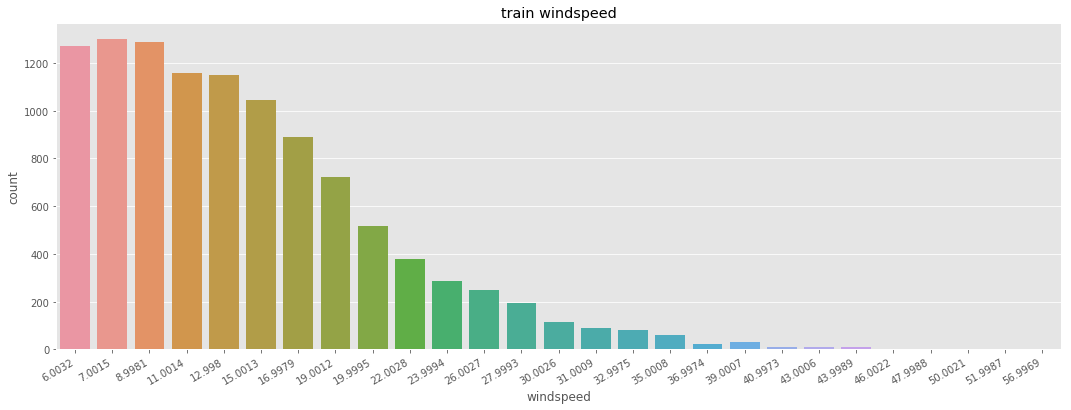

In [31]:
# 0값을 조정한다.
train = predict_windspeed(train)
# test = predict_windspeed(test)

# widspeed 의 0값을 조정한 데이터를 시각화
fig, ax1 = plt.subplots()
fig.set_size_inches(18,6)

plt.sca(ax1)
plt.xticks(rotation=30, ha='right')
ax1.set(ylabel='Count',title="train windspeed")
sns.countplot(data=train, x="windspeed", ax=ax1)

## Feature Selection

* 신호와 잡음을 구분해야 한다.
* 피처가 많다고 해서 무조건 좋은 성능을 내지 않는다.
* 피처를 하나씩 추가하고 변경해 가면서 성능이 좋지 않은 피처는 제거하도록 한다.

In [32]:
# 연속형 feature와 범주형 feature 
# 연속형 feature = ["temp","humidity","windspeed","atemp"]
# 범주형 feature의 type을 category로 변경 해 준다.
categorical_feature_names = ["season","holiday","workingday","weather",
                             "dayofweek","month","year","hour"]

for var in categorical_feature_names:
    train[var] = train[var].astype("category")
    test[var] = test[var].astype("category")

In [104]:
feature_names = ["season","weather","temp","humidity","windspeed","year","hour","holiday", "dayofweek", "workingday"]

feature_names

['season',
 'weather',
 'temp',
 'humidity',
 'windspeed',
 'year',
 'hour',
 'holiday',
 'dayofweek',
 'workingday']

* 여기서 원핫인코딩 생각할 수 있는데 ... 막상 해봐도 평가값 별 차이 없음

In [105]:
X_train  = train[feature_names]

print(X_train.shape)
X_train.head()

(10886, 10)


,season,weather,temp,humidity,windspeed,year,hour,holiday,dayofweek,workingday
0,1,2,9.84,75,6.0032,2011,5,0,5,0
1,1,1,15.58,76,16.9979,2011,10,0,5,0
2,1,1,14.76,81,19.0012,2011,11,0,5,0
3,1,1,17.22,77,19.0012,2011,12,0,5,0
4,1,2,18.86,72,19.9995,2011,13,0,5,0


In [106]:
X_test = test[feature_names]

print(X_test.shape)
X_test.head()

(6493, 10)


,season,weather,temp,humidity,windspeed,year,hour,holiday,dayofweek,workingday
0,1,1,10.66,56,26.0027,2011,0,0,3,1
1,1,1,10.66,56,0.0000,2011,1,0,3,1
2,1,1,10.66,56,0.0000,2011,2,0,3,1
3,1,1,10.66,56,11.0014,2011,3,0,3,1
4,1,1,10.66,56,11.0014,2011,4,0,3,1


In [107]:
label_name = "count"

y_train = train[label_name]

print(y_train.shape)
y_train.head()

(10886,)


0     1
1    36
2    56
3    84
4    94
Name: count, dtype: int64

In [97]:
from sklearn.metrics import make_scorer

def rmsle(predicted_values, actual_values):
    # 넘파이로 배열 형태로 바꿔준다.
    predicted_values = np.array(predicted_values)
    actual_values = np.array(actual_values)
    
    # 예측값과 실제 값에 1을 더하고 로그를 씌워준다.
    log_predict = np.log(predicted_values + 1)
    log_actual = np.log(actual_values + 1)
    
    # 위에서 계산한 예측값에서 실제값을 빼주고 제곱을 해준다.
    difference = log_predict - log_actual
    # difference = (log_predict - log_actual) ** 2
    difference = np.square(difference)
    
    # 평균을 낸다.
    mean_difference = difference.mean()
    
    # 다시 루트를 씌운다.
    score = np.sqrt(mean_difference)
    
    return score

rmsle_scorer = make_scorer(rmsle)
rmsle_scorer

make_scorer(rmsle)

In [111]:
from  sklearn.ensemble  import RandomForestRegressor

max_depth_list = []

model = RandomForestRegressor(n_estimators=150,
                              n_jobs=-1,
                              random_state=0)
model

model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=150, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [112]:
# 예측
predictions = model.predict(X_test)
submission = pd.read_csv("sampleSubmission.csv")
submission["count"] = predictions
print(submission.shape)
submission.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,11.960000
1,2011-01-20 01:00:00,4.853333
2,2011-01-20 02:00:00,4.233333
3,2011-01-20 03:00:00,3.213333
4,2011-01-20 04:00:00,2.926667


In [113]:
#제출용 파일 저장
submission.to_csv('Eric_kim_Rf.csv', sep=',', encoding='utf-8',index=False)

In [54]:
from sklearn.metrics import mean_squared_error
from math import sqrt
meanSquaredError=mean_squared_error(y_test, predictions)
rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)

NameError: name 'y_test' is not defined

In [64]:
from sklearn.linear_model import Lasso

In [65]:
lasso=Lasso(alpha=0.4,normalize=True)

In [66]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.4, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [86]:
X_train.columns

Index(['temp', 'humidity', 'hour', 'holiday', 'dayofweek', 'workingday'], dtype='object')

In [67]:
lasso_coef = lasso.coef_
print(lasso_coef)

[ 0.         -0.          3.25859935  0.         -0.35391893  6.9023968
  3.65233905  0.         -0.          0.        ]


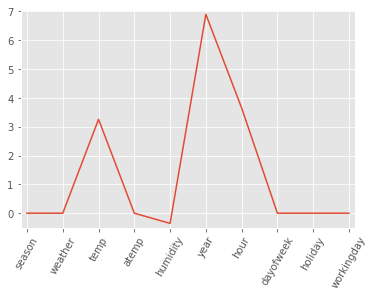

In [68]:
plt.plot(range(len(X_train.columns)), lasso_coef)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation=60)
plt.margins(0.02)
plt.show()


In [69]:
predictions_1 = lasso.predict(X_test)
submission_1 = pd.read_csv("sampleSubmission.csv")
submission_1["count"] = predictions_1
print(submission_1.shape)
submission_1.head()

(6493, 2)


,datetime,count
0,2011-01-20 00:00:00,116.851466
1,2011-01-20 01:00:00,120.503805
2,2011-01-20 02:00:00,124.156144
3,2011-01-20 03:00:00,127.808483
4,2011-01-20 04:00:00,131.460822


In [70]:
#제출용 파일 저장
submission_1.to_csv('Eric_kim_Lasso.csv', sep=',', encoding='utf-8',index=False)

In [51]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [52]:
meanSquaredError=mean_squared_error(y_train, predictions_1)
rootMeanSquaredError = sqrt(meanSquaredError)
print("RMSE:", rootMeanSquaredError)

ValueError: Found input variables with inconsistent numbers of samples: [10886, 6493]